# Targetting n&k or D or known parameters

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.LayeredExtractor import LayeredExtractorD, LayeredExtractorNK
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractorD, BayesianLayeredExtractorNK

[((3.46+0.01j), 0.001), ((2.5+0.015j), 0.0005)]


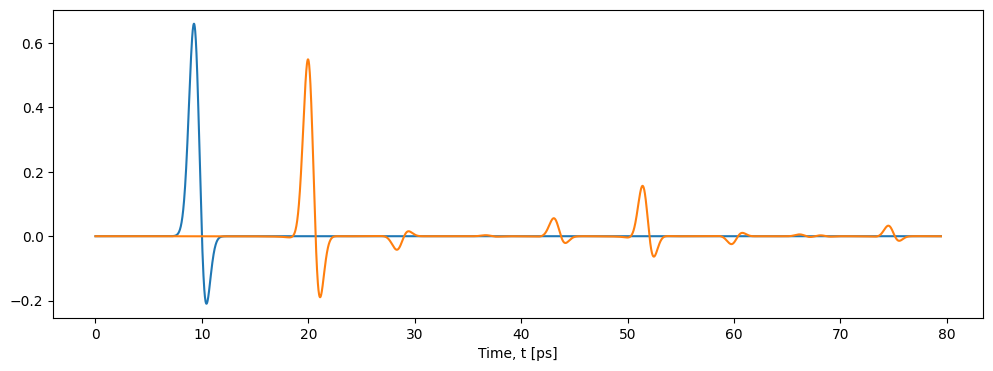

In [2]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, 0.01, 1e-3
n2, k2, d2= 2.5, 0.015, 0.5e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]

# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse)
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy())
plt.xlabel('Time, t [ps]')
plt.show()

## Fit just n's and k's for known d values

Starting Bayesian Optimization for n and k...
Bayesian Optimization complete.
[((3.4598476188406915+0.013087660116657513j), 0.001), ((2.49952336720811+0.008379607956062482j), 0.0005)]


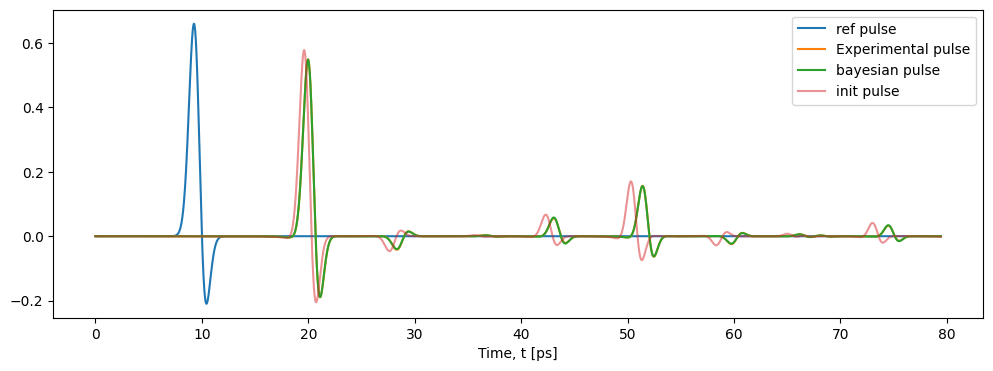

In [3]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

layers_nk_init = [(3.4+1j*0.015, 1e-3), (2.4+1j*0.017, 0.5e-3)]

initial_pulse_nk = simulate_parallel(reference_pulse, layers_nk_init, deltat, 0)[1][:L]

BLE_NK = BayesianLayeredExtractorNK(reference_pulse, experimental_pulse, deltat, layers_nk_init)
bayesian_NK_params = BLE_NK.bayesian_optimization(n_calls=30)
print(bayesian_NK_params)

_, bayesian_pulse_nk = simulate_parallel(reference_pulse, bayesian_NK_params, deltat, noise_level=0)
bayesian_pulse_nk = bayesian_pulse_nk[:L]

plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental pulse')
plt.plot(t_axis*1e12, bayesian_pulse_nk.detach().cpu().numpy(), label='bayesian pulse')
plt.plot(t_axis*1e12, initial_pulse_nk.detach().cpu().numpy(), label='init pulse', alpha=0.5)

plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Optimizing n and k with initial conditions [((3.4+0.015j), 0.001), ((2.4+0.017j), 0.0005)]
Optimizing for 50 iterations with loss multiplier 1.
Iteration 4, Loss: 0.0021321133244782686, Layer 0: n=3.459672689437866, k=0.012345729395747185, D=0.001, Layer 1: n=2.4993412494659424, k=0.008307572454214096, D=0.0005
Iteration 9, Loss: 0.0021216950844973326, Layer 0: n=3.4603867530822754, k=0.013067156076431274, D=0.001, Layer 1: n=2.5000905990600586, k=0.010057982057332993, D=0.0005
Iteration 14, Loss: 0.0020378706976771355, Layer 0: n=3.459886312484741, k=0.011925993487238884, D=0.001, Layer 1: n=2.499660015106201, k=0.010003961622714996, D=0.0005
Iteration 19, Loss: 0.00203052069991827, Layer 0: n=3.4601333141326904, k=0.01218470185995102, D=0.001, Layer 1: n=2.4999780654907227, k=0.011347922496497631, D=0.0005
Iteration 24, Loss: 0.001958709442988038, Layer 0: n=3.459925413131714, k=0.011339057236909866, D=0.001, Layer 1: n=2.4998207092285156, k=0.011585338041186333, D=0.0005
Iteration 2

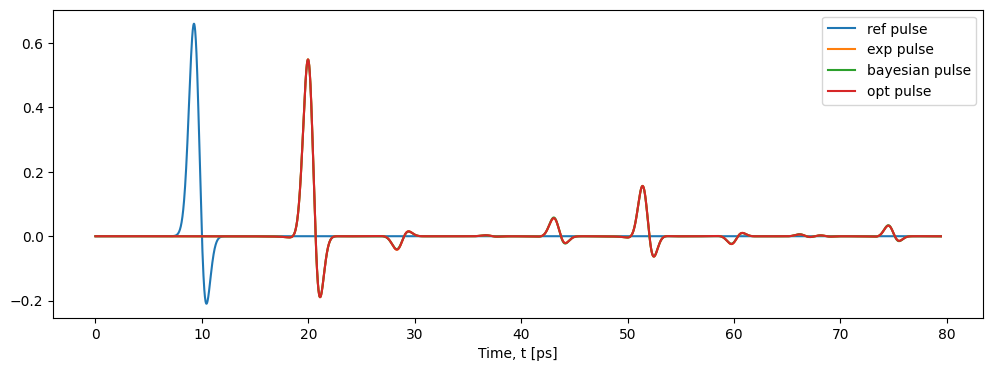

In [4]:
alpha = 1
LE_nk = LayeredExtractorNK(reference_pulse, experimental_pulse, deltat, bayesian_NK_params, lr=0.001)
print(f'Optimizing n and k with initial conditions {layers_nk_init}')
nj, kj = LE_nk.optimize(num_iterations=50, updates=5, alpha=alpha)

optim_params = [(nj[0]+1j*kj[0], d1), (nj[1]+1j*kj[1], d2)]

_, optimal_pulse_nk = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse_nk = optimal_pulse_nk[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, bayesian_pulse_nk.detach().cpu().numpy(), label='bayesian pulse')
plt.plot(t_axis*1e12, optimal_pulse_nk.detach().cpu().numpy(), label='opt pulse')

plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

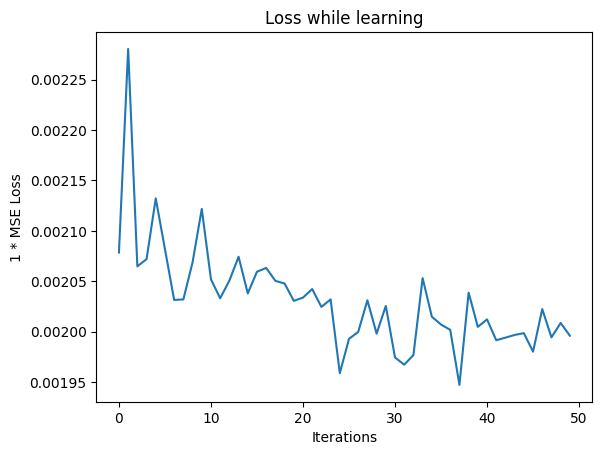

In [5]:
plt.plot(LE_nk.loss_history)
plt.xlabel('Iterations')
plt.ylabel(f'{alpha} * MSE Loss')
plt.title('Loss while learning')

plt.show()

### Plot residuals

In [6]:
n_res = np.zeros(len(optim_params))
k_res = np.zeros(len(optim_params))
i=0
for layer in optim_params:
    n_res[i] = np.real(layer[0]) - np.real(material_params_exp[i][0])
    k_res[i] = np.imag(layer[0]) - np.imag(material_params_exp[i][0])
    print(f'n residual for layer {i}: {n_res[i]}')
    print(f'k residual for layer {i}: {k_res[i]}')
    i+=1

n residual for layer 0: 2.422332763707402e-06
k residual for layer 0: 0.0006605142354965208
n residual for layer 1: -4.57763671875e-05
k residual for layer 1: -0.0015683224052190775


## Extract thicknesses of multiple layers

In [7]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

# Initial guess must be within 150um of the correct answer.
layers_D_init = [(n1+1j*k1, 0.9e-3), (n2+1j*k2, 0.4e-3)]
alpha = 10

initial_pulse = simulate_parallel(reference_pulse, layers_D_init, deltat, 0)[1][:L]

BLE_D = BayesianLayeredExtractorD(reference_pulse, experimental_pulse, deltat, layers_D_init, lr=0.01)
print(f'Optimizing n and k with initial conditions {layers_D_init}')
Dj = BLE_D.bayesian_optimization(n_calls=30)

Bayesian_params_D = [(n1+1j*k1, Dj[0]), (n2+1j*k2, Dj[1])]

_, Bayesian_pulse_D = simulate_parallel(reference_pulse, Bayesian_params_D, deltat, noise_level=0)
Bayesian_pulse_D = Bayesian_pulse_D[:L]

print(Bayesian_params_D)

Optimizing n and k with initial conditions [((3.46+0.01j), 0.0009), ((2.5+0.015j), 0.0004)]
Starting Bayesian Optimization...
Bayesian Optimization complete.
[((3.46+0.01j), 0.0010022064517180003), ((2.5+0.015j), 0.0004892960411666127)]


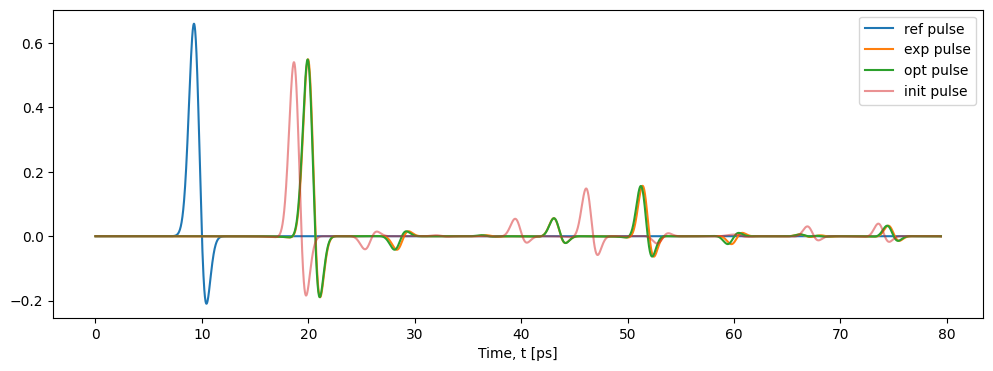

In [8]:
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, Bayesian_pulse_D.detach().cpu().numpy(), label='opt pulse')
plt.plot(t_axis*1e12, initial_pulse.detach().cpu().numpy(), label='init pulse', alpha=0.5)

plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

### Fine-tune on Adam

Optimizing n and k with initial conditions [((3.46+0.01j), 0.0009), ((2.5+0.015j), 0.0004)]
Optimizing for 50 iterations with loss multiplier 1.
Iteration 4, Loss: 0.008126224391162395, Layer 0: n=3.46, k=0.01, D=0.0009994531283155084, Layer 1: n=2.5, k=0.015, D=0.000489394529722631
Iteration 9, Loss: 0.007826745510101318, Layer 0: n=3.46, k=0.01, D=0.0010076224571093917, Layer 1: n=2.5, k=0.015, D=0.0004954613978043199
Iteration 14, Loss: 0.005372887477278709, Layer 0: n=3.46, k=0.01, D=0.0010016884189099073, Layer 1: n=2.5, k=0.015, D=0.0004948906716890633
Iteration 19, Loss: 0.002240628469735384, Layer 0: n=3.46, k=0.01, D=0.0010002903873100877, Layer 1: n=2.5, k=0.015, D=0.0004967376589775085
Iteration 24, Loss: 0.0034193159081041813, Layer 0: n=3.46, k=0.01, D=0.0010013378923758864, Layer 1: n=2.5, k=0.015, D=0.0004996064817532897
Iteration 29, Loss: 0.0021488440688699484, Layer 0: n=3.46, k=0.01, D=0.0010006929514929652, Layer 1: n=2.5, k=0.015, D=0.0005009538144804537
Iteration 

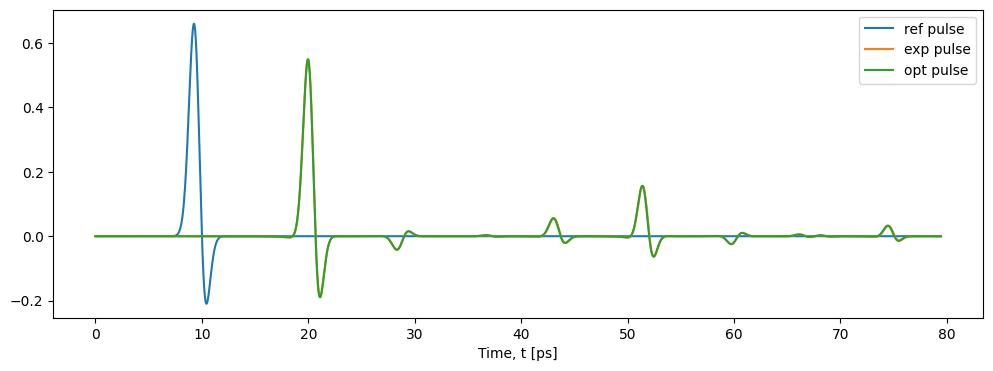

In [9]:
# Initial guess must be within 150um of the correct answer.
Bayesian_init_D = [(n1+1j*k1, Dj[0]), (n2+1j*k2, Dj[1])]

LE_D = LayeredExtractorD(reference_pulse, experimental_pulse, deltat, Bayesian_init_D, lr=0.01)
print(f'Optimizing n and k with initial conditions {layers_D_init}')
Dj_opt = LE_D.optimize(num_iterations=50, updates=5)

optim_params_D = [(n1+1j*k1, Dj_opt[0]), (n2+1j*k2, Dj_opt[1])]

_, optim_pulse_D = simulate_parallel(reference_pulse, optim_params_D, deltat, noise_level=0)
optim_pulse_D = optim_pulse_D[:L]

print(optim_params_D)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='exp pulse')
plt.plot(t_axis*1e12, optim_pulse_D.detach().cpu().numpy(), label='opt pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()